In [54]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

eda_middle_data_path = 'eda-middle-data/'

res = pd.DataFrame([], columns=['pcode', 'max_amplitude'])

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = eda_middle_data_path + participant_key + '_eda_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist!')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 20:
        print(file_path + ' has too less data!')
        continue
        
    res.loc[len(res)] = [participant_key, df['max_amplitude'].mean()]

# res.to_csv('hrv_result.csv', index=False)

res


eda-middle-data/P01_eda_result.csv has too less data!
eda-middle-data/P02_eda_result.csv has too less data!
eda-middle-data/P04_eda_result.csv has too less data!
eda-middle-data/P05_eda_result.csv has too less data!
eda-middle-data/P06_eda_result.csv has too less data!
eda-middle-data/P07_eda_result.csv has too less data!
eda-middle-data/P10_eda_result.csv has too less data!
eda-middle-data/P14_eda_result.csv has too less data!
eda-middle-data/P27_eda_result.csv do not exist!
eda-middle-data/P29_eda_result.csv has too less data!
eda-middle-data/P37_eda_result.csv has too less data!
eda-middle-data/P42_eda_result.csv has too less data!
eda-middle-data/P45_eda_result.csv has too less data!
eda-middle-data/P48_eda_result.csv has too less data!
eda-middle-data/P49_eda_result.csv has too less data!
eda-middle-data/P51_eda_result.csv has too less data!
eda-middle-data/P56_eda_result.csv has too less data!
eda-middle-data/P59_eda_result.csv do not exist!
eda-middle-data/P65_eda_result.csv do 

,pcode,max_amplitude
0,P03,0.296609
1,P08,0.102159
2,P09,0.008062
3,P11,0.052375
4,P12,0.131431
5,P13,0.091640
6,P15,0.332044
7,P16,0.174097
8,P17,0.151928
9,P18,0.160246


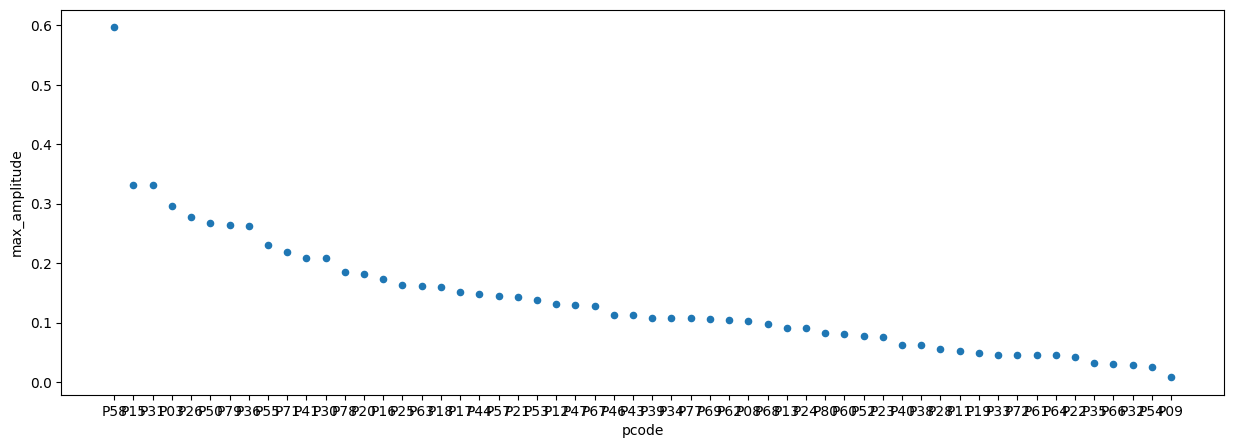

In [55]:
res.sort_values(by='max_amplitude', ascending=False, inplace=True)
plot = res.plot(x='pcode', y='max_amplitude', kind='scatter', figsize=(15, 5))

In [56]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


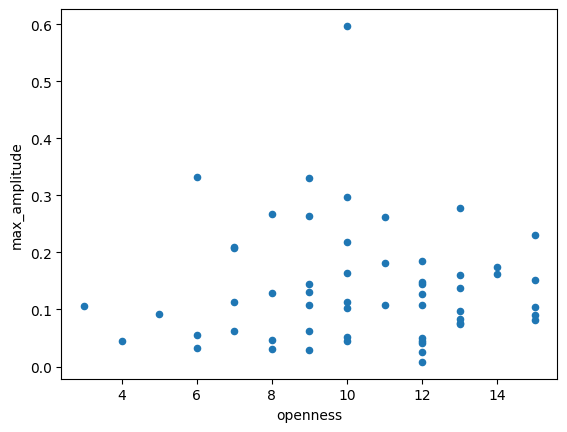

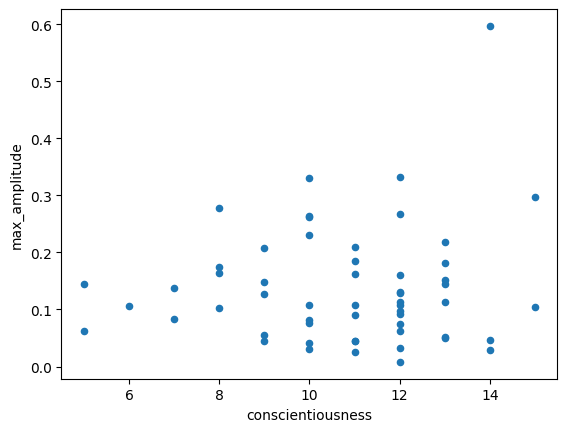

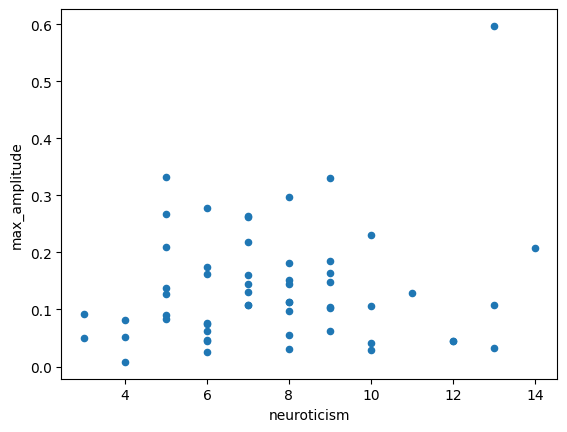

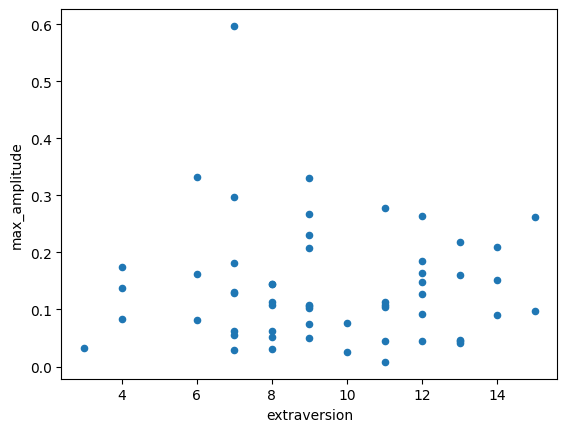

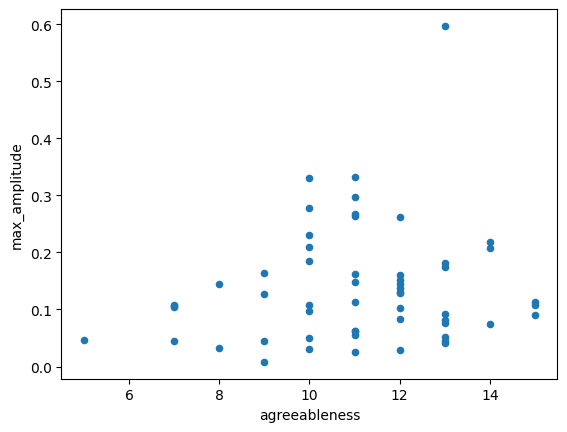

In [57]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

for trait in personality_traits:
    df_test.plot(x=trait, y='max_amplitude', kind='scatter')


In [58]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test['max_amplitude']

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:          max_amplitude   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.6365
Date:                Tue, 28 May 2024   Prob (F-statistic):              0.673
Time:                        14:30:51   Log-Likelihood:                 50.256
No. Observations:                  56   AIC:                            -88.51
Df Residuals:                      50   BIC:                            -76.36
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0376      0.12